In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np 
import torchvision

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
!mv /content/drive/MyDrive/lr1e-4epochs200.pth ./lr1e-4epochs200.pth

In [2]:
batch_size = 128
transform = transforms.Compose(
    [transforms.ToTensor(),])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 48, kernel_size=3), nn.ReLU(),
        nn.Conv2d(48, 128, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(128, 96, kernel_size=1, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 10, kernel_size=1), 
        nn.AvgPool2d(kernel_size=8),
    )
  def forward(self, x):
    logits = self.net(x)
    return logits.view(-1, 10)

In [50]:
classifier = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet44", pretrained=True)
classifier = classifier.cuda()
classifiervgg = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg16_bn", pretrained=True)
classifiervgg = classifiervgg.cuda()

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [8]:
def accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy: %s %%' % (100 * correct / total))

In [9]:
accuracy(classifier)

Accuracy: 91.31 %


In [24]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    layers = [
              nn.Conv2d(3, 64, 5, padding=2, stride=2), nn.BatchNorm2d(64, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(64, 128, 5, padding=2, stride=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(128, 256, 5, padding=2, stride=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Flatten(), nn.Linear(256*4*4, 2048), nn.BatchNorm1d(2048, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Linear(2048, 118),
    ]
    self.net = nn.Sequential(*layers)

  def forward(self,x):
    return self.net(x)

In [25]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
              nn.Linear(128, 256*4*4), nn.BatchNorm1d(256*4*4, momentum=0.9), nn.LeakyReLU(0.2),
              )
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(256,256,6, stride=2, padding=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(256,128,6, stride=2, padding=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128,32,6, stride=2, padding=2), nn.BatchNorm2d(32, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32,3,5, stride=1, padding=2), nn.Tanh()
    )

  def forward(self, x):
    x = self.linear(x)
    x = x.view(-1, 256, 4, 4)
    return self.conv(x)

In [30]:
class Generator(nn.Module):
  def __init__(self, epsilon):
    super().__init__()
    self.decoder = Decoder()
    self.encoder = Encoder()
    self.classifier = classifiervgg
    self.epsilon = epsilon
    for param in classifier.parameters():
      param.requires_grad = False

  def loss(self, x, y, gen_labels):
    one_hot = F.one_hot(gen_labels, 10).cuda()
    z = torch.cat((self.encoder(x), one_hot), 1)
    perturbation = epsilon * self.decoder(z)
    logits = self.classifier(x+perturbation)
    predictions = F.softmax(logits, 1)
    loss = nn.CrossEntropyLoss()
    return loss(classifier(x+perturbation), gen_labels), perturbation

In [43]:
labels = [torch.randint(0,10, (128,)).cuda() for i in range(391)]

In [52]:
!pip install cleverhans

     |████████████████████████████████| 92 kB 198 kB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 154 kB 63.6 MB/s 


In [51]:
epsilon = 0.04
epochs = 20
model = Generator(epsilon).cuda()
model.load_state_dict(torch.load("lr1e-4epochs200.pth"))
optimizer = torch.optim.Adam(classifiervgg.parameters(), 1e-4)
lossfn = nn.CrossEntropyLoss()



for epoch in range(epochs):
  for i, (x,y) in enumerate(train_loader):
    x,y = x.cuda(), y.cuda()
    gen_labels = labels[i][:x.shape[0]]
    _, perturbation = model.loss(x,y,gen_labels)
    optimizer.zero_grad()
    loss = lossfn(classifiervgg(x+perturbation), y)
    loss.backward()
    optimizer.step()
    


    if (i%100 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch+1, epochs, i+1, len(train_loader), loss.item()))
  
  adv_accuracy(classifiervgg)

Epoch [1/20], Step [1/391], Loss: 9.202374458312988
Epoch [1/20], Step [101/391], Loss: 0.4628281593322754
Epoch [1/20], Step [201/391], Loss: 0.346591055393219
Epoch [1/20], Step [301/391], Loss: 0.15838225185871124
Adversarial accuracy: 88.3 %
Epoch [2/20], Step [1/391], Loss: 0.16441915929317474
Epoch [2/20], Step [101/391], Loss: 0.11129514873027802
Epoch [2/20], Step [201/391], Loss: 0.08612478524446487
Epoch [2/20], Step [301/391], Loss: 0.099466972053051
Adversarial accuracy: 88.72 %
Epoch [3/20], Step [1/391], Loss: 0.08233027905225754
Epoch [3/20], Step [101/391], Loss: 0.12743933498859406
Epoch [3/20], Step [201/391], Loss: 0.04240206629037857
Epoch [3/20], Step [301/391], Loss: 0.10392647981643677
Adversarial accuracy: 88.93 %
Epoch [4/20], Step [1/391], Loss: 0.05587313324213028


KeyboardInterrupt: ignored

In [33]:
def adv_accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
          outputs = net(model.loss(images, labels, gen_labels)[1] + images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Adversarial accuracy: %s %%' % (100 * correct / total))

In [34]:
adv_accuracy(classifier)

Adversarial accuracy: 27.01 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

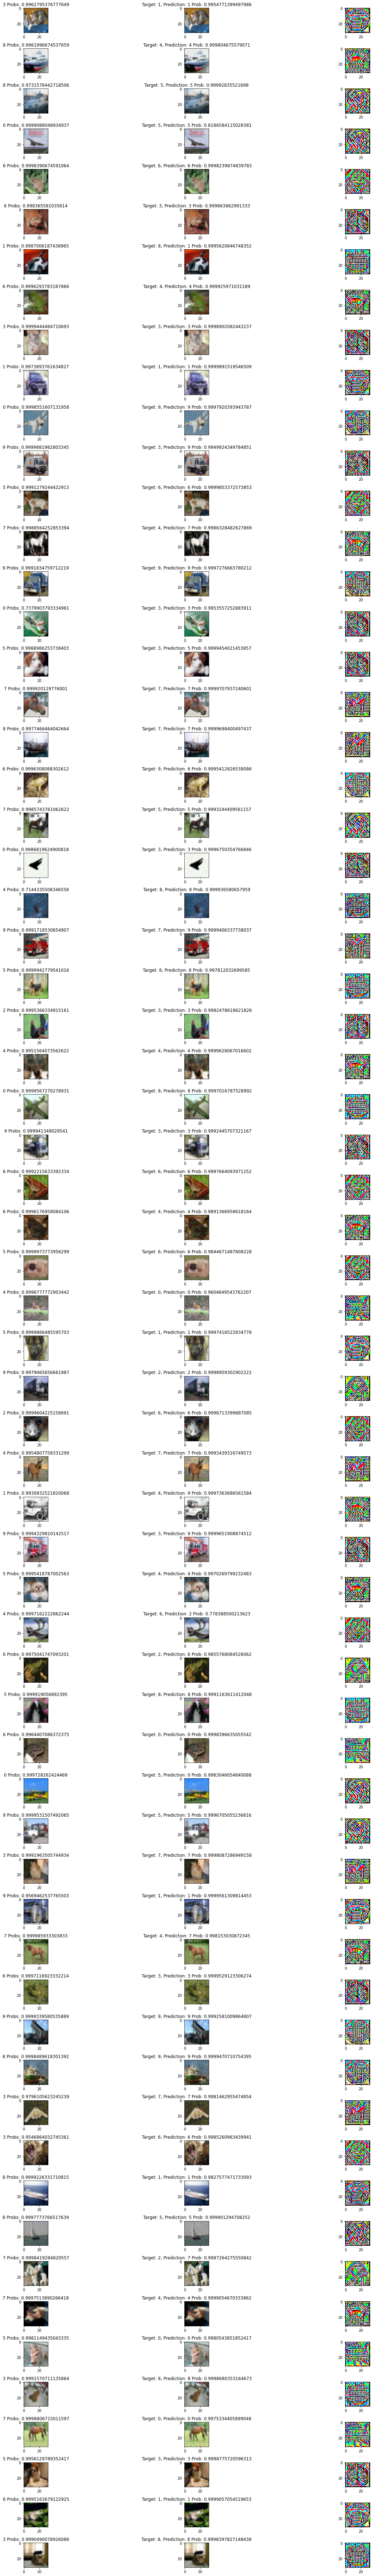

In [ ]:
for x,y in test_loader:
  gen_labels = torch.randint(0,10, (128,)).cuda()
  x,y = x.cuda(), y.cuda()
  base_predictions = F.softmax(classifier(x), 1)
  _, perturbations = model.loss(x,y, gen_labels)
  new_predictions = F.softmax(classifier(x+perturbations), 1)
  fig, axs = plt.subplots(64, 3)
  fig.set_figheight(100)
  fig.set_figwidth(20)
  images = []
  for i in range(64):
          image, perturbation = x[i].detach().cpu().numpy().transpose(1,2,0), perturbations[i].detach().cpu().numpy().transpose(1,2,0)
          images.append(axs[i, 0].imshow(image))
          axs[i,0].title.set_text(f'{torch.argmax(base_predictions[i]).item()} Probs: {torch.max(base_predictions[i]).item()}')
          images.append(axs[i,1].imshow(image+perturbation))
          axs[i,1].title.set_text(f'Target: {gen_labels[i]}, Prediction: {torch.argmax(new_predictions[i]).item()} Prob: {torch.max(new_predictions[i]).item()}')
          images.append(axs[i,2].imshow(perturbation/epsilon, cmap='gray'))
  break

plt.tight_layout()
plt.show()

In [60]:
from absl import app, flags
from easydict import EasyDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)

untrainedvgg = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg16_bn", pretrained=True)
untrainedvgg = untrainedvgg.cuda()

class CNN(torch.nn.Module):
    """Basic CNN architecture."""

    def __init__(self, in_channels=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 8, 1)
        self.conv2 = nn.Conv2d(64, 128, 6, 2)
        self.conv3 = nn.Conv2d(128, 128, 5, 2)
        self.fc = nn.Linear(128 * 3 * 3, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 3 * 3)
        x = self.fc(x)
        return x


def ld_cifar10():
    """Load training and test data."""
    train_transforms = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor()]
    )
    test_transforms = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor()]
    )
    train_dataset = torchvision.datasets.CIFAR10(
        root="/tmp/data", train=True, transform=train_transforms, download=True
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root="/tmp/data", train=False, transform=test_transforms, download=True
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=128, shuffle=True, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=128, shuffle=False, num_workers=2
    )
    return EasyDict(train=train_loader, test=test_loader)


def main():
    # Load training and test data
    data = ld_cifar10()

    # Instantiate model, loss, and optimizer for training
    net = classifiervgg
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == "cuda":
        net = net.cuda()
    loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    # Train vanilla model

    # Evaluate on clean and adversarial data
    net.eval()
    report = EasyDict(nb_test=0, correct=0, correct_fgm=0, correct_pgd=0)
    for x, y in data.test:
        x, y = x.to(device), y.to(device)
        x_fgm = fast_gradient_method(untrainedvgg, x, 0.03, np.inf)
        x_pgd = projected_gradient_descent(untrainedvgg, x, 0.03, 0.01, 40, np.inf)
        _, y_pred = untrainedvgg(x).max(1)  # model prediction on clean examples
        _, y_pred_fgm = untrainedvgg(x_fgm).max(
            1
        )  # model prediction on FGM adversarial examples
        _, y_pred_pgd = untrainedvgg(x_pgd).max(
            1
        )  # model prediction on PGD adversarial examples
        report.nb_test += y.size(0)
        report.correct += y_pred.eq(y).sum().item()
        report.correct_fgm += y_pred_fgm.eq(y).sum().item()
        report.correct_pgd += y_pred_pgd.eq(y).sum().item()
    print(
        "test acc on clean examples (%): {:.3f}".format(
            report.correct / report.nb_test * 100.0
        )
    )
    print(
        "test acc on FGM adversarial examples (%): {:.3f}".format(
            report.correct_fgm / report.nb_test * 100.0
        )
    )
    print(
        "test acc on PGD adversarial examples (%): {:.3f}".format(
            report.correct_pgd / report.nb_test * 100.0
        )
    )


main()

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified
Files already downloaded and verified
test acc on clean examples (%): 87.360
test acc on FGM adversarial examples (%): 79.040
test acc on PGD adversarial examples (%): 77.250


In [61]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified
Files already downloaded and verified
test acc on clean examples (%): 33.200
test acc on FGM adversarial examples (%): 18.530
test acc on PGD adversarial examples (%): 16.380
